In [1]:
import json

# Load the enriched JSON
with open("../3. Feed Scraped Data/sri_lanka_safaris_with_features.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [2]:
import networkx as nx

G = nx.Graph()

In [3]:
for item in data:
    tour_id = item["title"]
    G.add_node(tour_id, type="tour", label=tour_id)
    
    # --- Park Names as Locations ---
    parks = item.get("extracted_features", {}).get("park_names", [])
    for park in parks:
        G.add_node(park, type="location", label=park)
        G.add_edge(tour_id, park, relation="located_in")

    # --- Wildlife Focus ---
    wildlife = item.get("extracted_features", {}).get("primary_wildlife_focus")
    if wildlife:
        G.add_node(wildlife, type="wildlife", label=wildlife)
        G.add_edge(tour_id, wildlife, relation="has_focus")

    # --- Safari Type (Jeep Safari, Private Safari) ---
    safari_types = item.get("extracted_features", {}).get("safari_type_detail", [])
    for safari in safari_types:
        G.add_node(safari, type="safari_type", label=safari)
        G.add_edge(tour_id, safari, relation="has_type")

    # --- Key Attractions ---
    attractions = item.get("extracted_features", {}).get("key_attractions", [])
    for attr in attractions:
        G.add_node(attr, type="attraction", label=attr)
        G.add_edge(tour_id, attr, relation="has_attraction")

    # --- Duration Category ---
    duration = item.get("extracted_features", {}).get("duration_category")
    if duration:
        G.add_node(duration, type="duration", label=duration)
        G.add_edge(tour_id, duration, relation="has_duration")

    # --- Price Category ---
    price = item.get("extracted_features", {}).get("price_category")
    if price:
        G.add_node(price, type="price", label=price)
        G.add_edge(tour_id, price, relation="has_price")

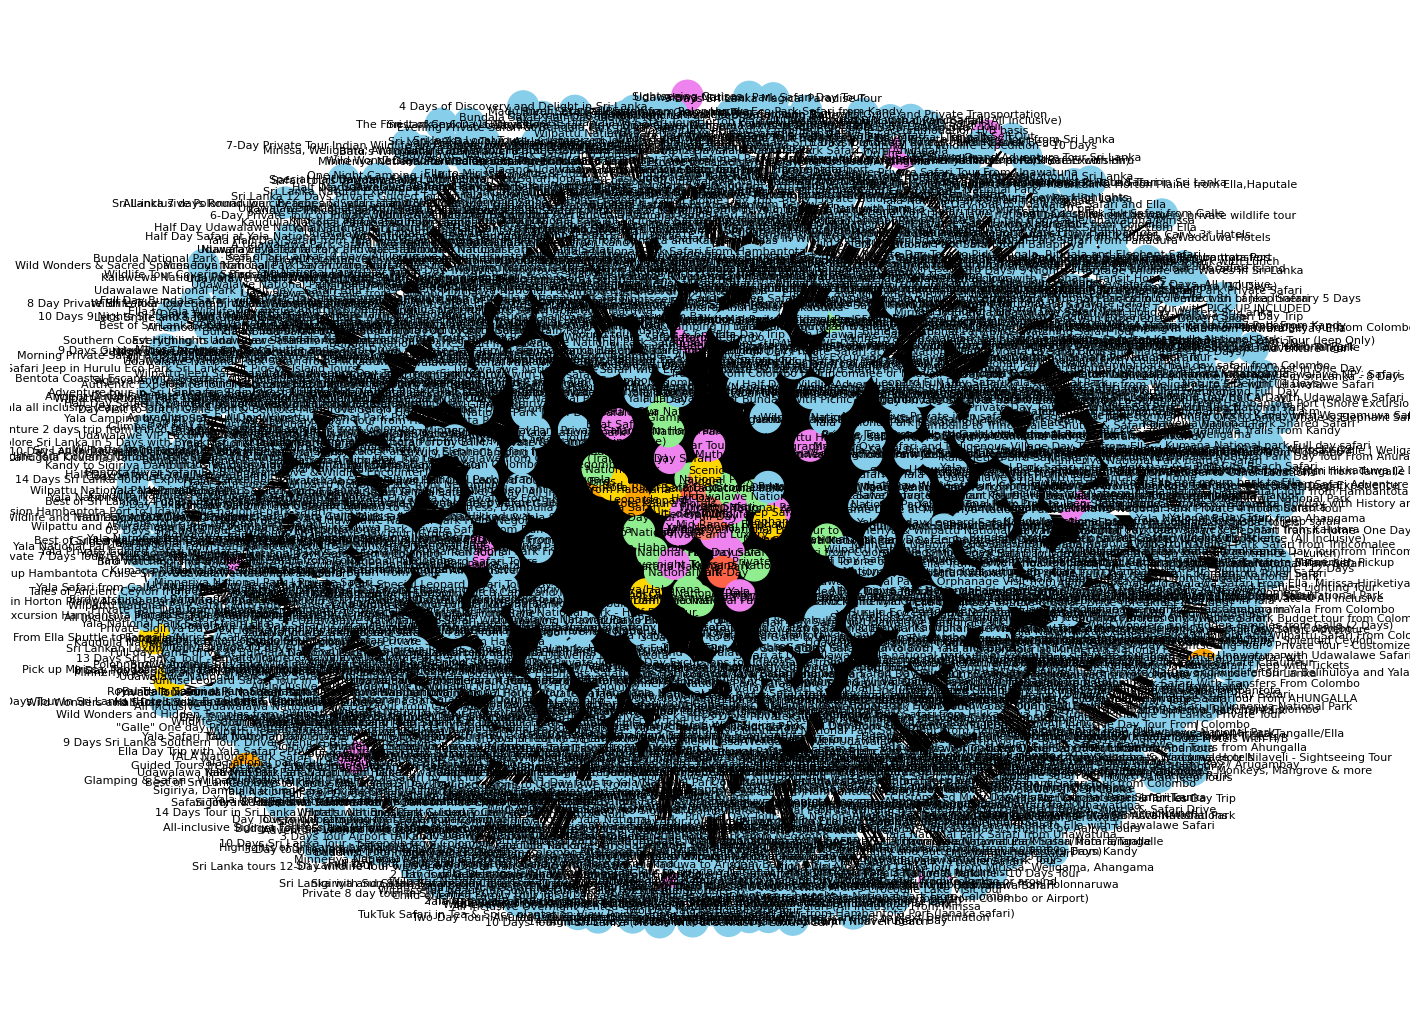

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)

# Color nodes by type
colors = []
for node, attr in G.nodes(data=True):
    if attr['type'] == 'tour':
        colors.append('skyblue')
    elif attr['type'] == 'location':
        colors.append('lightgreen')
    elif attr['type'] == 'wildlife':
        colors.append('orange')
    elif attr['type'] == 'safari_type':
        colors.append('violet')
    elif attr['type'] == 'attraction':
        colors.append('gold')
    elif attr['type'] == 'duration':
        colors.append('tomato')
    elif attr['type'] == 'price':
        colors.append('salmon')
    else:
        colors.append('gray')

nx.draw(G, pos, with_labels=True, node_color=colors, font_size=8, node_size=500)
plt.show()

In [ ]:
# Example 1: Find all tours related to a tag (e.g., "Elephant")
def get_tours_by_tag(graph, tag_label, relation_type="has_attraction"):
    tours = []
    for neighbor in graph.neighbors(tag_label):
        if graph.nodes[neighbor].get("type") == "tour":
            # Check the edge type
            if graph.get_edge_data(tag_label, neighbor).get("relation") == relation_type or \
               graph.get_edge_data(neighbor, tag_label).get("relation") == relation_type:
                tours.append(neighbor)
    return tours

elephant_tours = get_tours_by_tag(G, "Elephant")
print("Elephant-related Tours:\n", elephant_tours)

Elephant-related Tours:
 ['Private Jeep Safari at Minneriya National Park to Visit Elephants', 'Udawalawe National Park | Private Safari Tour', 'Minneriya National Park Elephant Jeep Safari Private Tour', 'Safari Tour at Minneriya National Park', 'Yala National Park Safari Tours -Half Day & Full Day', 'Minneriya National Park Half day Jeep Safari with Hotel Pickup', 'Yala National Park Morning or Afternoon Leopard Safari', 'Bundala National Park Birds Watching Safari Tour', 'Private Jeep Safari To one of a Best National Park', 'Minneriya National Park Elephant Safari', 'Udawalawa Safari & Elephants Orphanage Tour from Hambantota port', 'Wasgamuwa National Park Private Safari', 'Minneriya National Park Half Day safari', 'Explore The Beauty Of Udawalawe National Park From South Coast During 01 Day', 'Half Day - Minneriya National Park Safari Tour From Habarana/Sigiriya', 'Minneriya Elephant Safari Drive From Trincomalee', 'Minneriya Half Day Safari Tour', 'Maduru Oya National Park Privat

In [8]:
# Example 2: Get all tours in a given national park (e.g., “Yala National Park”)
def get_tours_by_location(graph, location_name):
    return get_tours_by_tag(graph, location_name, relation_type="located_in")

yala_tours = get_tours_by_location(G, "Yala National Park")
print("Tours in Yala:\n", yala_tours)

Tours in Yala:
 ['Ella: Transfer to Tangalle/Mirissa/Galle & Yala/Udawalawe Safari', 'Yala National Park Wildlife Safari/ Game Drive - by Ajith Safari', 'Special leopards safari Yala National park - 04.30 am to 11.30 am', 'Full day Safari - Yala National Park - 04.30 am to 06.00 pm with - Janaka safari', 'Yala National Park Special Leopard Safari\xa0Tours By Dinuka Safari', 'Full day / Half Day WildlifeAdventure in Yala-National-Park', 'Yala National Park Tour From Hambantota Port', 'Yala National Park Safari Tours -Half Day & Full Day', 'Yala Safari Private Day Trip with Return Transport -All Inclusive', 'Yala National Park Safari Tours - Half Day & Full Day', 'Day Excursion from Colombo to Yala Safari (Leopard Safari Tour)', 'Leopard Safari Tour in Yala National Park', 'Yala National Park Safari Tour From Hambantota port', 'From Ella Shuttle to Tangalle/Mirissa/Galle with Yala Safari Tour', 'Yala National Park Morning or Afternoon Leopard Safari', 'Yala Safari Tour from Hambantota Po

In [9]:
# Build Rule-Based Roadmap (Path Style)
# Start with an Elephant Safari → then do a Jeep Safari in the same park.
 
def get_custom_roadmap(graph, focus="Elephant", safari_type="Jeep Safari"):
    tours = []
    for node in graph.nodes:
        if graph.nodes[node].get("type") == "tour":
            neighbors = list(graph.neighbors(node))
            tags = [n for n in neighbors if graph.nodes[n].get("type") in ["attraction", "safari_type"]]
            if focus in tags and safari_type in tags:
                tours.append(node)
    return tours

custom_plan = get_custom_roadmap(G, focus="Elephant", safari_type="Jeep Safari")
print("Custom Roadmap Tour Candidates:\n", custom_plan)

Custom Roadmap Tour Candidates:
 ['Private Jeep Safari at Minneriya National Park to Visit Elephants', 'Minneriya National Park Elephant Jeep Safari Private Tour', 'Minneriya National Park Half day Jeep Safari with Hotel Pickup', 'Private Jeep Safari To one of a Best National Park', 'Kaudulla National Park Safari | Jeep with Tickets', 'Kaudulla National Park Jeep Safari From Trincomalee & Nilaveli', 'Udawalawe National Park Unforgettable Safari Jeep Experience', 'Udawalawa Safari(3-4hours) - Private Jeep with Experienced Driver', 'Yala Private Safari Jeep Half Day', 'Udawalawe Elephant Safari: 3h Jeep Adventure (All Inclusive)', 'Private Jeep Safari at Minneriya National Park', 'Jeep safari Minneriya / Kaudulla National Park', 'Private Minneriya National Park Jeep Safari And Sigiriya Tour', 'Elephant Transit Home Udawalawe with Jeep safari from Colombo', 'Udawalawe National Park Safari | Jeep with Tickets', 'Kaudulla national park from Colombo inclusive of jeep safari', 'Udawalawe Nati

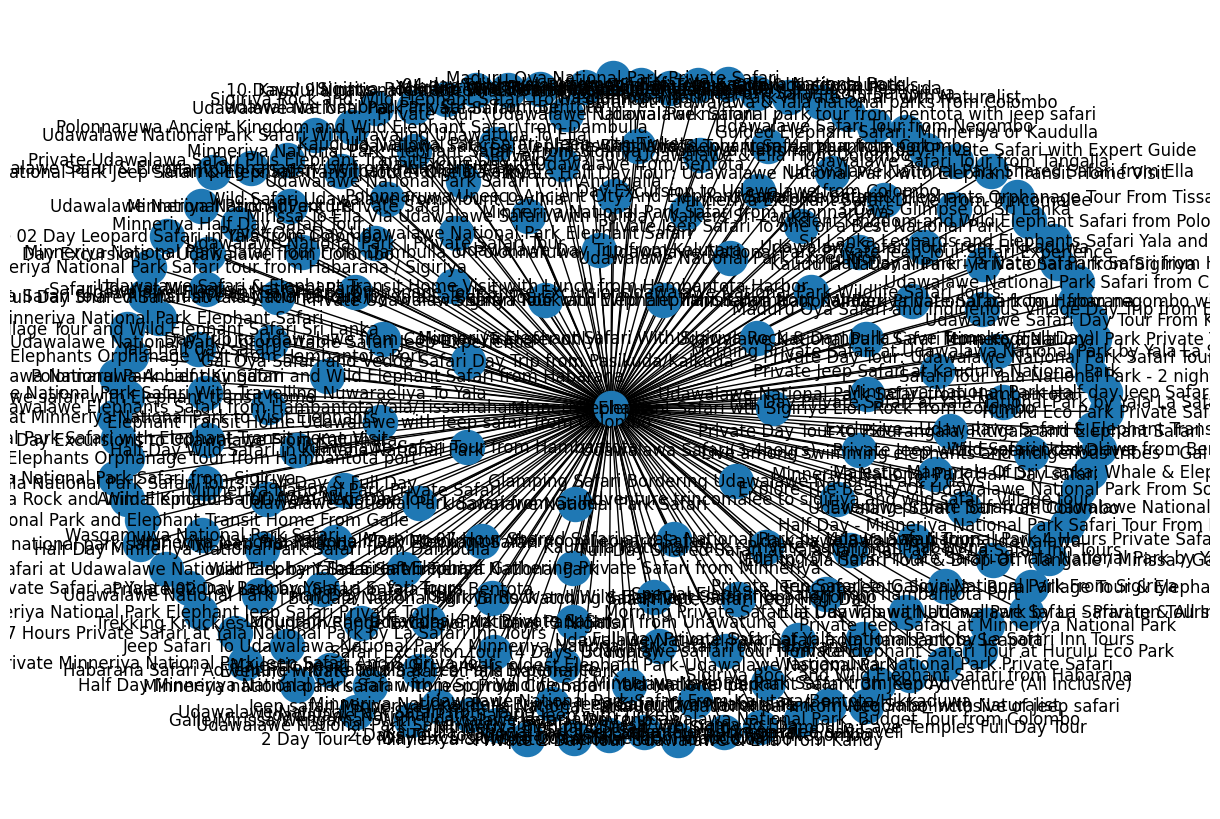

In [12]:
# extract and visualize only the subgraph relevant to the user query
def visualize_subgraph(graph, nodes):
    import matplotlib.pyplot as plt
    sub = graph.subgraph(nodes)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(sub, k=0.6)
    nx.draw(sub, pos, with_labels=True, node_size=600)
    plt.show()

# safari_tours = get_tours_by_tag(G, "Elephant")
visualize_subgraph(G, ["Elephant"] + elephant_tours)


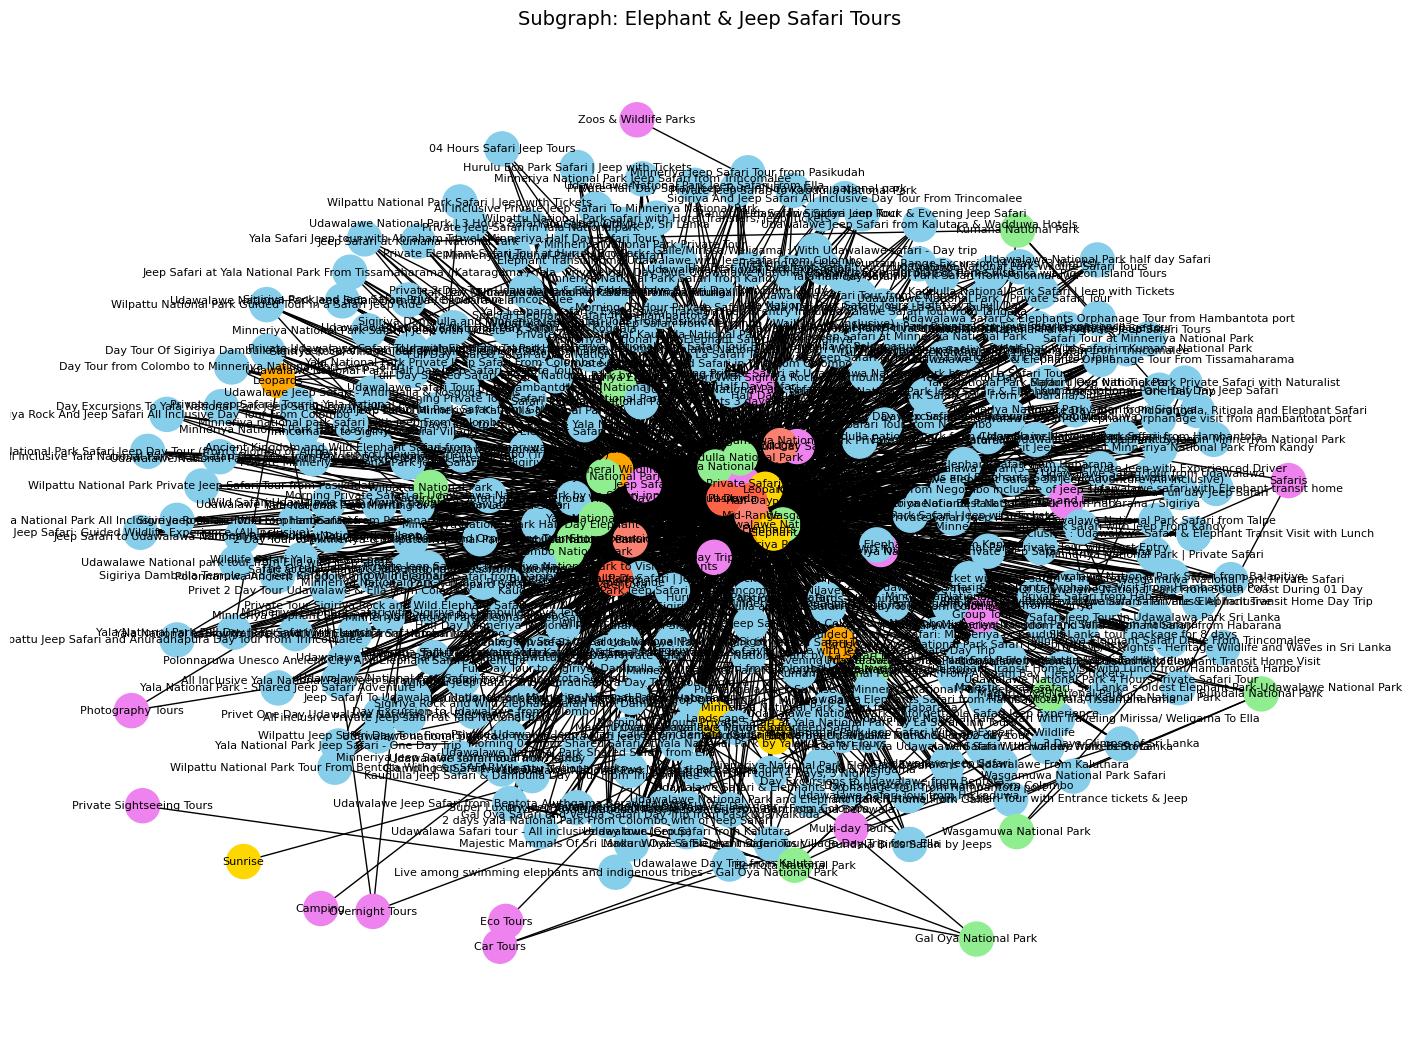

In [13]:
def visualize_elephant_and_jeep_safari_subgraph(graph):
    import matplotlib.pyplot as plt

    # Step 1: Get neighbors of "Elephant" and "Jeep Safari"
    elephant_tours = [n for n in graph.neighbors("Elephant") if graph.nodes[n].get("type") == "tour"]
    jeep_tours = [n for n in graph.neighbors("Jeep Safari") if graph.nodes[n].get("type") == "tour"]

    # Step 2: Merge node list
    nodes_to_include = set(elephant_tours + jeep_tours + ["Elephant", "Jeep Safari"])

    # Optional: include tags or locations connected to those tours
    for tour in elephant_tours + jeep_tours:
        nodes_to_include.update(graph.neighbors(tour))  # Add connected nodes (like park names, durations)

    # Step 3: Create subgraph
    sub = graph.subgraph(nodes_to_include)

    # Step 4: Visualize
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(sub, k=0.6)

    # Color by node type
    color_map = []
    for node in sub.nodes(data=True):
        ntype = node[1].get("type")
        if ntype == "tour":
            color_map.append("skyblue")
        elif ntype == "location":
            color_map.append("lightgreen")
        elif ntype == "wildlife":
            color_map.append("orange")
        elif ntype == "safari_type":
            color_map.append("violet")
        elif ntype == "attraction":
            color_map.append("gold")
        elif ntype == "duration":
            color_map.append("tomato")
        elif ntype == "price":
            color_map.append("salmon")
        else:
            color_map.append("gray")

    nx.draw(sub, pos, with_labels=True, node_color=color_map, node_size=600, font_size=8)
    plt.title("Subgraph: Elephant & Jeep Safari Tours", fontsize=14)
    plt.show()

# Run it
visualize_elephant_and_jeep_safari_subgraph(G)
